This Kaggle dataset is about customer conversion on Google's Google Merchandise Store (also known as GStore, where Google swag is sold). The main purpose of this analysis is to predict revenue per customer and make recommandations on promotional strategies. The main technical challenge it poses to predicting revenue is the presence of multiple high cardinality categorical features. By careful data exploration followed by well-thought choice of feature treatments as well as machine learning algorithm, I show that an optimal solution based on feature-engineering and extreme gradient-boosted decision trees yields an enhanced predictive power of 0.997, as measured by the area under the precision-recall curve. Crucially, these results were obtained without artificial balancing of the data making this approach suitable to real-world applications.

<a id='top'></a>
#### Outline: 
#### 1. <a href='#Sampling'>Random sampling of training set</a>
#### 2. <a href='#EDA'>Exploratory Data Analysis</a>

#### 3. <a href='#clean'>Data Cleaning</a>
31. <a href='#cleanID'>Cleaning of IDs</a>
32. <a href='#cleanTotals'>Cleaning of Variable Totals</a>
33. <a href='#cleanTS'>Cleaning of Time Series Variables</a>
34. <a href='#cleanLoc'>Cleaning of Location Variables</a>
35. <a href='#cleanDev'>Cleaning of Device Variables</a>
36. <a href='#cleanCust'>Cleaning of Custom Dimension Variables</a>


#### 4. <a href='#feature-eng'>Feature Engineering</a>
41. <a href='#dropUnif'> Drop uninformative categorical varibles</a>
42. <a href='#dropMissing'>Drop variables with too many missing values</a>
43. <a href='#encodeCat'>Encode Categorical Variables</a>
44. <a href='#encodeCat1'>Encode Network Domain</a>
45. <a href='#encodeCat2'>Encode Operating Systems</a>


#### 5. <a href='#ML'>Machine Learning to Predict Transactions</a>
51. <a href='#rfEnum'>Random Forest with Enum Encoding</a>
52. <a href='#gbmEnum'>GBM with Enum Encoding</a>
53. <a href='#gbmTarget'>GBM with sort_by_response Encoding</a>
54. <a href='#gbmTargetDev'>GBM with Target Encoding Channel/Device Analysis</a>


#### 6. <a href='#visualization'>Visualization</a>
61. <a href='#varimp'>Variable Importance Plot</a>
62. <a href='#pdp'>Partial Dependency Plot</a>
63. <a href='#pdp2dim'>Two Variable Partial Dependency Plot</a>
64. <a href='#Treeplot'>Major Decision Trees Plot</a>


#### 7. <a href='#conclusion'>Conclusion</a>

In [4]:
import pandas as pd
import json
import random
import csv
import numpy as np
from datetime import datetime

In [5]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
seaborn.set(rc={'figure.figsize':(15,12)})

In [6]:
import subprocess
from IPython.display import Image

In [7]:
def json_to_series(text):
    keys, values = zip(*[item for item in json.loads(text).items()])
    return pd.Series(values, index=keys)

<a id='Sampling'></a>
# 1.Random sample 90000 rows of training set
<a href='#top'>back to top</a>

In [ ]:
filename = ".\\all\\train_v2.csv"

In [ ]:
n = sum(1 for line in open(filename,encoding="utf8")) - 1 

In [ ]:
s = 90000
skip = sorted(random.sample(range(1,1708337+1),1708337-s))
train_top = pd.read_csv(filename,skiprows=skip)

In [ ]:
train_top.to_csv("train_top.csv",index=False)

In [6]:
df = pd.read_csv("train_top.csv")

<a id='clean'></a>
# 3.Data Cleaning

<a id='cleanID'></a>
### 3.1 Clean ID
<a href='#top'>back to top</a>

sessionId = fullVisitorId_visitId    
visitNumber may be strong indicators since it means the visitor comes back multiple times

In [7]:
ct = df.groupby(by='fullVisitorId')['visitId'].count()
visitn = df.groupby(by='fullVisitorId')['visitNumber'].max()
visitn = pd.concat([visitn,ct],axis=1)

In [8]:
df.drop(['visitNumber','hits','trafficSource'],axis=1,inplace=True)

<a id='cleanTotals'></a>
### 3.2 Clean Totals
<a href='#top'>back to top</a>

In [9]:
df = pd.concat([df, df['totals'].apply(json_to_series)], axis=1)

In [10]:
df.drop(['totals'],axis=1,inplace=True)

In [11]:
#df['hits'] = df['hits'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['pageviews'] = df['pageviews'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['newVisits'] = df['newVisits'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['visits'] = df['visits'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['bounces'] = df['bounces'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['transactionRevenue'] = df['transactionRevenue'].map(lambda x: int(x) if not pd.isnull(x) else 0)
df['totalTransactionRevenue'] = df['totalTransactionRevenue'].map(lambda x: int(x) if not pd.isnull(x) else 0)

In [12]:
df.drop(['totalTransactionRevenue'],axis=1,inplace=True)

In [13]:
df['log_transactionRevenue'] = df['transactionRevenue'].map(lambda x:np.log(x+1))

<a id='cleanTS'></a>
### 3.3 Clean Time Series
<a href='#top'>back to top</a>

In [14]:
df['date'] = pd.to_datetime(df['date'],format="%Y%m%d")
df['week'] = df['date'].map(lambda x: x.isocalendar()[1])
df['day_of_week'] = df['date'].map(lambda x: x.isocalendar()[2])

In [15]:
df.drop(['date'],axis=1,inplace=True)

In [16]:
df["visitStartTime"] = df["visitStartTime"].map(lambda x:datetime.utcfromtimestamp(x).hour)

<a id='cleanLoc'></a>
### 3.4 Clean Location
<a href='#top'>back to top</a>

In [17]:
df = pd.concat([df, df['geoNetwork'].apply(json_to_series)], axis=1)

In [18]:
df.drop(['geoNetwork'],axis=1,inplace=True)

<a id='cleanDev'></a>
### 3.5 Clean Device
<a href='#top'>back to top</a>

In [19]:
df = pd.concat([df, df['device'].apply(json_to_series)], axis=1)

In [20]:
df.drop(['device'],axis=1,inplace=True)

<a id='cleanCust'></a>
### 3.6 Clean customDimensions
<a href='#top'>back to top</a>

In [21]:
df['customDimensions'] = df['customDimensions'].map(lambda x: x[1:-1])

In [22]:
df['customDimensions'] = df['customDimensions'].map(lambda x: x.replace("'","\""))

In [23]:
df.loc[df['customDimensions']=="",'customDimensions'] = "{\"index\":\"NaN\",\"value\":\"NaN\"}"

In [24]:
df = pd.concat([df, df['customDimensions'].apply(json_to_series)], axis=1)

In [25]:
df.drop(['customDimensions'],axis=1,inplace=True)

<a id='feature-eng'></a>
# 4.Feature Cleaning
<a href='#top'>back to top</a>

In [26]:
ID = ["fullVisitorId","visitId"]

<a id='dropUnif'></a>
### 4.1 Drop uninformative categorical varibles
<a href='#top'>back to top</a>

In [27]:
for col in df.columns:
    cn = df[col].value_counts()
    if cn.shape[0]==1:
        df.drop(col,axis=1,inplace=True)

<a id='dropMissing'></a>
### 4.2 Drop variables with too many missing values
<a href='#top'>back to top</a>

In [28]:
df.replace("not available in demo dataset",np.NaN,inplace=True)

In [29]:
df.replace("NaN",np.NaN,inplace=True)

In [30]:
df.replace("(not set)",np.NaN,inplace=True)

In [31]:
na_df = np.sum(df.isna(),axis=0)/df.shape[0]
na_df[na_df>0.1]

timeOnSite           0.513856
sessionQualityDim    0.488111
transactions         0.989322
region               0.577833
metro                0.773100
city                 0.588144
networkDomain        0.291833
index                0.197367
value                0.197367
dtype: float64

In [32]:
df.drop(['index',"isMobile","transactions","metro"],axis=1,inplace=True)

<a id='encodeCat'></a>
### 4.3 Encode Categorical Variables
<a href='#top'>back to top</a>

In [58]:
import category_encoders as ce

<a id='encodeCat1'></a>
### 4.3.1 Encode Categorical Variables -- networkDomain
<a href='#top'>back to top</a>

In [34]:
df.loc[df['networkDomain'].isna(),'networkDomain'] = 'unknown.unknown'

df["raw_networkDomain"] = df["networkDomain"]

In [35]:
min_sample_leaf = int(df.shape[0]*0.005)

encoder = ce.TargetEncoder(cols=["networkDomain"],min_samples_leaf=min_sample_leaf,smoothing=1)

In [36]:
encoder.fit(df.loc[:,~df.columns.isin(["transactionRevenue","log_transactionRevenue"])], df["log_transactionRevenue"])

TargetEncoder(cols=['networkDomain'], drop_invariant=False,
       handle_unknown='impute', impute_missing=True, min_samples_leaf=450,
       return_df=True, smoothing=1.0, verbose=0)

In [37]:
df_x = encoder.transform(df.loc[:,~df.columns.isin(["transactionRevenue","log_transactionRevenue"])])

In [38]:
df['networkDomain'] = df_x['networkDomain']

In [59]:
networkDomain_dict={}

for k,g in df.groupby(by=['networkDomain']):
    
    if len(g['raw_networkDomain'].unique())<=10:
        networkDomain_dict[k] = list(g['raw_networkDomain'].unique())
    else:
        networkDomain_dict[k] = ['Others']
        

<a id='encodeCat2'></a>
### 4.3.2 Encode Categorical Variables -- operating Systems
<a href='#top'>back to top</a>

In [40]:
df['raw_operatingSystem'] = df['operatingSystem']

In [41]:
min_sample_leaf = int(df.shape[0]*0.005)

encoder = ce.TargetEncoder(cols=["operatingSystem"],min_samples_leaf=min_sample_leaf,smoothing=1)

In [42]:
encoder.fit(df.loc[:,~df.columns.isin(["transactionRevenue","log_transactionRevenue"])], df["log_transactionRevenue"])

TargetEncoder(cols=['operatingSystem'], drop_invariant=False,
       handle_unknown='impute', impute_missing=True, min_samples_leaf=450,
       return_df=True, smoothing=1.0, verbose=0)

In [43]:
df_x = encoder.transform(df.loc[:,~df.columns.isin(["transactionRevenue","log_transactionRevenue"])])

In [44]:
df['operatingSystem'] = df_x['operatingSystem']

In [60]:
operatingSystem_dict={}

for k,g in df.groupby(by=['operatingSystem']):
    
    if len(g['raw_operatingSystem'].unique())<=10:
        operatingSystem_dict[k] = list(g['raw_operatingSystem'].unique())
    else:
        operatingSystem_dict[k] = ['Others']
       

In [46]:
df.to_csv("train.csv",index=False)

<a id='EDA'></a>
# 2. Exploratory Data Analysis
<a href='#top'>back to top</a>

t-nse plot
identify outliers
correlation matrix

Check response variable's distribution

After Removing 0 transaction revenues and take log transformation, the distribution is with moderate skewness.

In [8]:
Path = "train.csv"
df = pd.read_csv(Path)

In [9]:
names_y = "log_transactionRevenue"
ig_cols = ['fullVisitorId','visitId','raw_networkDomain','transactionRevenue','raw_operatingSystem']

In [10]:
given_types = {'channelGrouping':'enum', 'fullVisitorId':'numeric', 'visitId':'numeric', 'visitStartTime':'enum', 
               'hits':'numeric','pageviews':'numeric', 'timeOnSite':'numeric', 'newVisits':'enum', 
               'sessionQualityDim':'numeric','transactionRevenue':'numeric', 'bounces':'enum', 'week':'enum', 
               'day_of_week':'enum', 'continent':'enum','subContinent':'enum', 'country':'enum', 'region':'enum', 
               'city':'enum', 'raw_networkDomain':'enum', 'browser':'enum','operatingSystem':"numeric",
               'deviceCategory':'enum', 'value':'enum','networkDomain':'numeric',"log_transactionRevenue":"numeric",
              "raw_operatingSystem":"enum"}

In [11]:
names_x = list(given_types.keys())
names_x.remove("log_transactionRevenue")              
names_x = [i for i in names_x if i not in ig_cols ]

In [12]:
cat = []
numeric = []
for name in names_x:
    if given_types[name] == 'enum':
        cat.append(name)
    elif given_types[name] == 'numeric':
        numeric.append(name)
numeric.remove('operatingSystem')
numeric.remove('networkDomain')
print(cat)
print(numeric)

['channelGrouping', 'visitStartTime', 'newVisits', 'bounces', 'week', 'day_of_week', 'continent', 'subContinent', 'country', 'region', 'city', 'browser', 'deviceCategory', 'value']
['hits', 'pageviews', 'timeOnSite', 'sessionQualityDim']


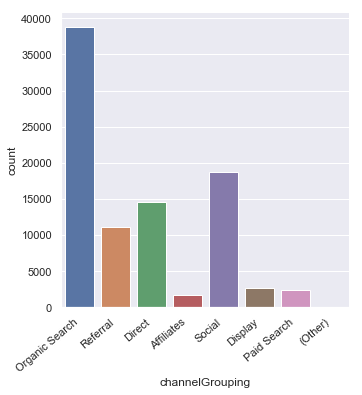

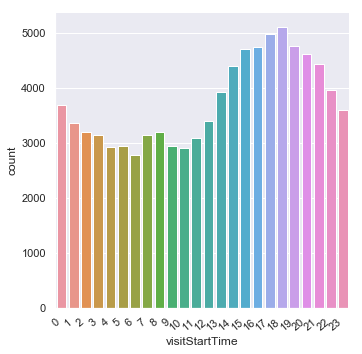

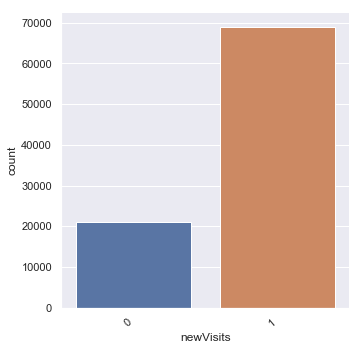

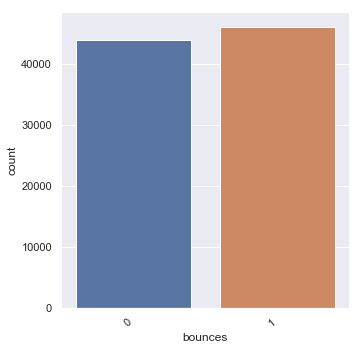

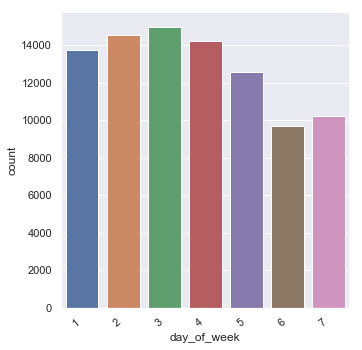

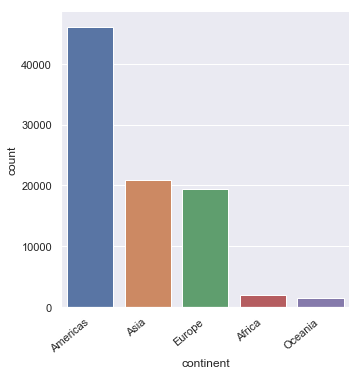

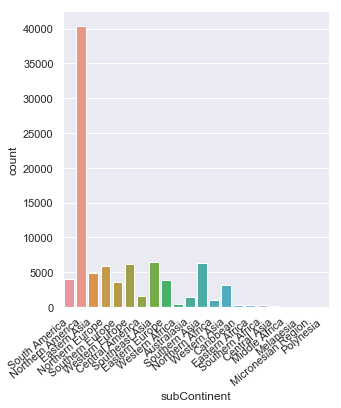

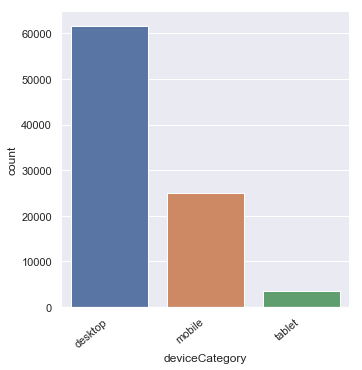

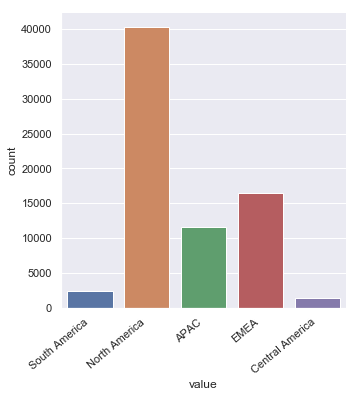

In [55]:
for name in cat:
    if len(df[name].unique())<25:
        g = seaborn.catplot(x=name,kind='count',data=df)
        g.set_xticklabels(rotation=40,ha='right')

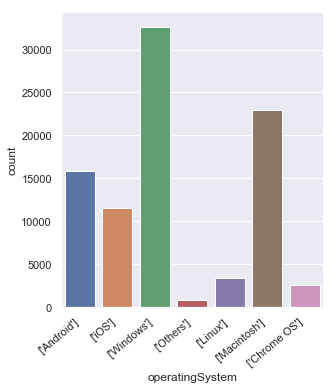

In [66]:
g = seaborn.catplot(x='operatingSystem',kind='count',data=df)
g.set_xticklabels(labels=operatingSystem_dict.values(),rotation=40,ha='right')   

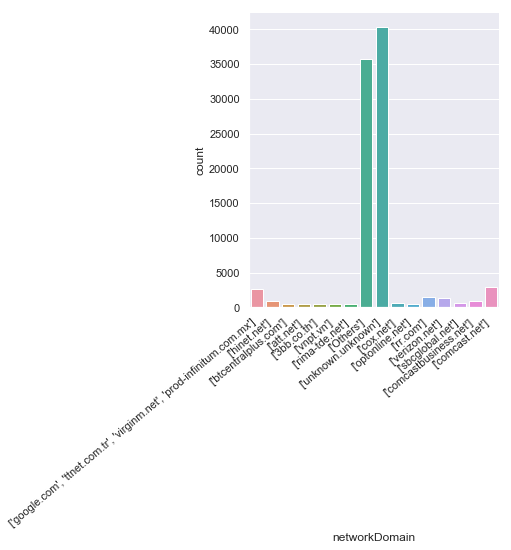

In [67]:
g = seaborn.catplot(x='networkDomain',kind='count',data=df)
g.set_xticklabels(labels=networkDomain_dict.values(),rotation=40,ha='right')   

#### Pair Plot

C:\Users\XuL\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\XuL\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


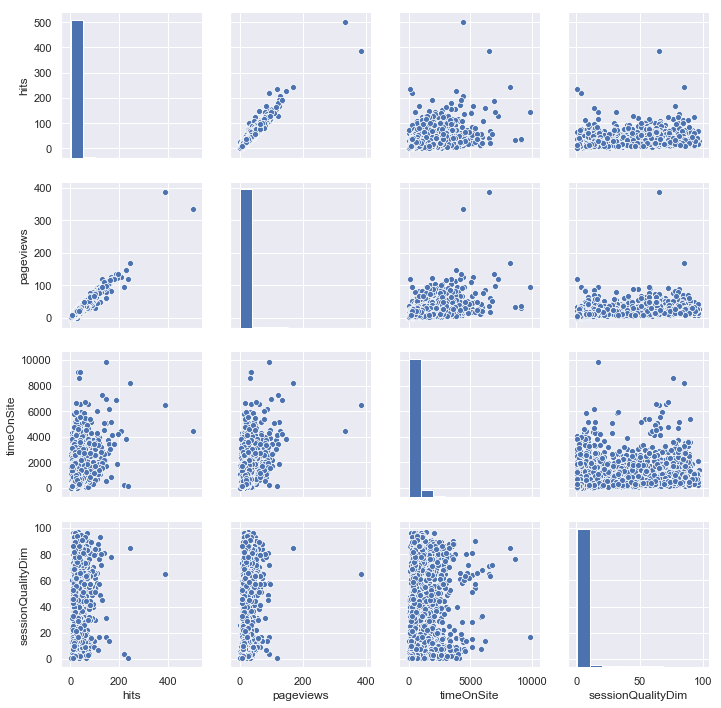

In [81]:
seaborn.pairplot(df.loc[:,df.columns.isin(numeric)],height=2.5);

In [76]:
df[df.pageviews==df.hits].shape

(74176, 26)

In [77]:
df.shape

(90000, 26)

C:\Users\XuL\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\XuL\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


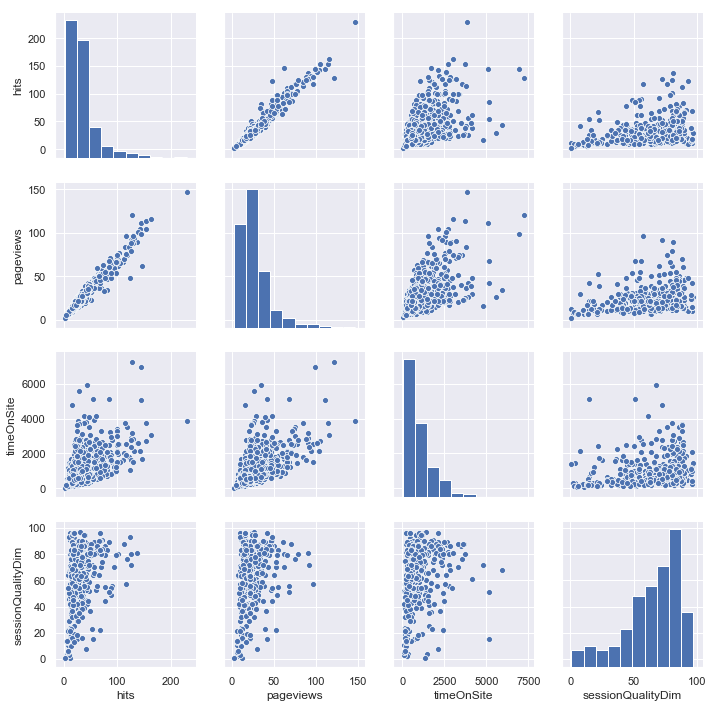

In [82]:
seaborn.pairplot(df.loc[df.log_transactionRevenue!=0,df.columns.isin(numeric)],height=2.5);

Comments:
Numeric features are highly skewed
Hits and pageviews are highly correlated

Q: How to interpret targe value encoding for Cat Variables for Variance Importance Plot?

A: Not acurate; biased towards high cardinality

Q:How to group cat variables with high cardinality for visualization?

A: Use target encoding and grouping sample size < n to be "Others" category.




Q:PDF Box Interpret partial dependence plot?

Q: How to identify and remove outliers?

Grid Search

<a id='ML'></a>
# 5.Machine Learning to Predict Transactions
<a href='#top'>back to top</a>

In [ ]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
h2o.init()

In [34]:
Path = "train.csv"
df = pd.read_csv(Path)

In [35]:
names_y = "log_transactionRevenue"
ig_cols = ['fullVisitorId','visitId','raw_networkDomain','transactionRevenue','raw_operatingSystem']

In [36]:
given_types = {'channelGrouping':'enum', 'fullVisitorId':'numeric', 'visitId':'numeric', 'visitStartTime':'enum', 
               'hits':'numeric','pageviews':'numeric', 'timeOnSite':'numeric', 'newVisits':'enum', 
               'sessionQualityDim':'numeric','transactionRevenue':'numeric', 'bounces':'enum', 'week':'enum', 
               'day_of_week':'enum', 'continent':'enum','subContinent':'enum', 'country':'enum', 'region':'enum', 
               'city':'enum', 'raw_networkDomain':'enum', 'browser':'enum','operatingSystem':"numeric",
               'deviceCategory':'enum', 'value':'enum','networkDomain':'numeric',"log_transactionRevenue":"numeric",
              "raw_operatingSystem":"enum"}

In [ ]:
train = h2o.H2OFrame(df,column_types=given_types)

In [ ]:
types = train.types

In [38]:
cat = []
for key,value in types.items():
    if value == 'enum':
        cat.append(key)
print(cat)

['channelGrouping', 'visitStartTime', 'newVisits', 'bounces', 'week', 'day_of_week', 'continent', 'subContinent', 'country', 'region', 'city', 'raw_networkDomain', 'browser', 'deviceCategory', 'value', 'raw_operatingSystem']


In [40]:
names_x = list(types.keys())
names_x.remove("log_transactionRevenue")              
names_x = [i for i in names_x if i not in ig_cols ]

In [ ]:
train,test,te_holdout,valid = train.split_frame(ratios=[0.7,0.1,0.1])

<a id='rfEnum'></a>
### 5.1 Random Forest with Enum Encoding
<a href='#top'>back to top</a>

In [ ]:
drf0 = H2ORandomForestEstimator(ntrees=300, max_depth=8, nfolds=8,nbins_cats=10)

In [ ]:
drf0.train(x=names_x,y=names_y,
             training_frame=train,
             validation_frame=valid)

In [ ]:
train_mse_drf = drf0.model_performance(train.rbind(valid)).mse()
test_mse_drf  = drf0.model_performance(test).mse()

In [ ]:
print("train_mse: {0:.3f}".format(train_mse_drf))
print("test_mse: {0:.3f}".format(test_mse_drf))

In [ ]:
drf0.varimp_plot()

<a id='gbmEnum'></a>
### 5.2 GBM with Enum Encoding
<a href='#top'>back to top</a>

In [ ]:
gbm0 = H2OGradientBoostingEstimator(ntrees=300,max_depth=6,nfolds=8,nbins_cats=10,learn_rate=0.01,sample_rate=0.6)

In [ ]:
gbm0.train(x=names_x,y=names_y,
             training_frame=train,
             validation_frame=valid)

In [ ]:
train_mse_gbm = gbm0.model_performance(train.rbind(valid)).mse()
test_mse_gbm = gbm0.model_performance(test).mse()

In [ ]:
print("train_mse: {0:.3f}".format(train_mse_gbm))
print("test_mse: {0:.3f}".format(test_mse_gbm))

In [ ]:
gbm0.varimp_plot()

XGboost 
mean absolute errors

<a id='gbmTarget'></a>
### 5.3 GBM with sort_by_response Encoding
<a href='#top'>back to top</a>

In [ ]:
gbm1 = H2OGradientBoostingEstimator(ntrees=300,max_depth=6,nfolds=8,nbins_cats=10,learn_rate=0.01,sample_rate=0.6,
categorical_encoding='sort_by_response')

In [ ]:
names_x.remove("networkDomain")
names_x.append("raw_networkDomain")
names_x.remove("operatingSystem")
names_x.append("raw_operatingSystem")

In [ ]:
gbm1.train(x=names_x,y=names_y,
             training_frame=train,
             validation_frame=valid)

In [ ]:
train_mse_gbm = gbm1.model_performance(train.rbind(valid)).mse()
test_mse_gbm = gbm1.model_performance(test).mse()

In [ ]:
print("train_mse: {0:.3f}".format(train_mse_gbm))
print("test_mse: {0:.3f}".format(test_mse_gbm))

In [ ]:
gbm1.varimp_plot()

<a id='gbmTargetDev'></a>
### 5.4 GBM with Target Encoding Channel/Device Analysis
<a href='#top'>back to top</a>

In [ ]:
sessionQuality = ['pageviews','sessionQualityDim','timeOnSite','hits']
names_x_sub = [i for i in names_x if i not in sessionQuality ]

In [ ]:
gbm2 = H2OGradientBoostingEstimator(ntrees=300,max_depth=5,nfolds=5,nbins_cats=5,learn_rate=0.01,sample_rate=0.67,
                                   categorical_encoding='sort_by_response')

In [ ]:
gbm2.train(x=names_x_sub,y=names_y,
             training_frame=train,
             validation_frame=valid)

In [ ]:
train_mse_gbm = gbm2.model_performance(train.rbind(valid)).mse()
test_mse_gbm = gbm2.model_performance(test).mse()

In [ ]:
prediction = gbm2.predict(test)

In [ ]:
print("train_mse: {0:.3f}".format(train_mse_gbm))
print("test_mse: {0:.3f}".format(test_mse_gbm))

In [ ]:
gbm2.varimp_plot()

<a id='visualization'></a>
# 6. Visualization
<a href='#top'>back to top</a>

<a id='varimp'></a>
### 6.1 Variable Importance Plot
<a href='#top'>back to top</a>

##### Mac OS
path=""
mojo_file_name = 'gbm2.zip'
modelfile = gbm2.download_mojo(mojo_file_name,get_genmodel_jar=False)
print("Model saved to " + modelfile)

In [ ]:
path = 'C://Users//XuL//Desktop//kaggle'
mojo_file_name = '//model//gbm0.zip'
modelfile = gbm0.download_mojo(path+mojo_file_name,get_genmodel_jar=False)
print("Model saved to " + modelfile)

<a id='pdp'></a>
### 6.2 Partial Dependency Plot
<a href='#top'>back to top</a>

In [ ]:
def lineplot_ci(pdp,x_name,ttl,cat_type,figsize=[10,6],**kwargs):
    
    if cat_type=='int':
        pdp[x_name] = pdp[x_name].map(lambda x: int(x))
    elif cat_type=='float':
        pdp[x_name] = pdp[x_name].map(lambda x: float(x))
        
    pdp.sort_values(by=x_name,ascending=True,inplace=True)

    pdp['95%CI_lower'] = pdp['mean_response']-pdp['std_error_mean_response']*0.95
    pdp['95%CI_higher'] = pdp['mean_response']+pdp['std_error_mean_response']*0.95

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(pdp[x_name],pdp['mean_response'],label='mean')
    ax.fill_between(pdp[x_name], pdp['95%CI_lower'],  \
                    pdp['95%CI_higher'], color='b', alpha=.1, label="95% CI")

    ax.scatter(pdp[x_name],pdp['mean_response'],color='r')
    ax.set_xticks(pdp[x_name])
    
    if not kwargs == None:
        if 'rotation' in kwargs.keys():
            ax.set_xticklabels(labels=pdp[x_name], rotation=kwargs['rotation'],ha="right")
           
    ax.legend(loc=0)
    ax.set_xlabel(ttl)
    ax.grid(True,linestyle='--')
    ax.set_title(ttl+" Partial Dependency Plot")
    
    return pdp

In [ ]:
pdp = gbm0.partial_plot(train.rbind(valid),["channelGrouping"])
pdp = pdp[0].as_data_frame()
plt.close()
pdp_cg = lineplot_ci(pdp,"channelgrouping","channelGrouping",'str')

In [ ]:
pdp = gbm0.partial_plot(train.rbind(valid),["value"])
pdp = pdp[0].as_data_frame()
plt.close()
pdp = lineplot_ci(pdp,"value".lower(),"value",'str')

In [ ]:
pdp = gbm0.partial_plot(train.rbind(valid),["visitStartTime"],nbins=24)
pdp = pdp[0].as_data_frame()
plt.close()
pdp = lineplot_ci(pdp,"visitStartTime".lower(),"visitStartTime",'int')

In [ ]:
pdp = gbm0.partial_plot(train.rbind(valid),["week"],nbins=52)
pdp = pdp[0].as_data_frame()
plt.close()
pdp = lineplot_ci(pdp,"week","week",'int',figsize=[14,10])

In [ ]:
pdp = gbm0.partial_plot(train.rbind(valid),["day_of_week"],nbins=7)
pdp = pdp[0].as_data_frame()
plt.close()
pdp = lineplot_ci(pdp,"day_of_week","day_of_week",'int')

In [ ]:
pdp = gbm0.partial_plot(train.rbind(valid),["operatingSystem"],nbins=7,
                       user_splits={"operatingSystem":list(operatingSystem_dict.keys())})
pdp = pdp[0].as_data_frame()
plt.close()

In [ ]:
pdp['name'] = pdp['operatingsystem'].map(lambda x: " ".join(operatingSystem_dict[x]))

In [ ]:
pdp = lineplot_ci(pdp,"name","operatingSystem",'str',[14,8])

In [ ]:
pdp = gbm0.partial_plot(train.rbind(valid),["deviceCategory"],nbins=7)
pdp = pdp[0].as_data_frame()
plt.close()

In [ ]:
pdp = lineplot_ci(pdp,"devicecategory","deviceCategory",'str')

In [ ]:
pdp = gbm0.partial_plot(train.rbind(valid),["networkDomain"],nbins=14,
                        user_splits={"networkDomain":list(networkDomain_dict.keys())})
pdp = pdp[0].as_data_frame()
plt.close()

In [ ]:
pdp['name'] = pdp['networkdomain'].map(lambda x: " ".join(networkDomain_dict[x]))

In [ ]:
pdp = lineplot_ci(pdp,"name","networkDomain","str",figsize=[14,10],rotation=40)

<a id='pdp2dim'></a>
### 6.3 Two Variable Partial Dependency Plot
<a href='#top'>back to top</a>

In [ ]:
from pdpbox import pdp, get_dataset, info_plots

In [ ]:
pdp_day_of_week = pdp.pdp_isolate(
    model=gbm2, dataset=train.rbind(valid), model_features=names_x_sub, feature='day_of_week'
)
fig, axes = pdp.pdp_plot(pdp_day_of_week, 'day_of_week', plot_lines=True, frac_to_plot=100)

<a id='Treeplot'></a>
### 6.4 Major Decision Trees Plot
<a href='#top'>back to top</a>

##### mac os
h2o_jar_path= '../../../h2o/h2o.jar'
gv_file_path = "graph/my_gbm_graph"
image_file_path = "image/my_gbm_tree"

In [ ]:
h2o_jar_path= 'H://h2o.jar'
gv_file_path = ".//graph//my_gbm_graph"
image_file_path = ".//image//my_gbm_tree"

In [ ]:
def generateTree(h2o_jar_path, mojo_file_path, gv_file_path, path, tree_id = 0):

    gv_file_path = path + gv_file_path + "_" + str(tree_id) + ".gv"
    mojo_file_path = path + mojo_file_path
    
    cmd = ["java", "-cp", h2o_jar_path, \
    "hex.genmodel.tools.PrintMojo", "--tree", str(tree_id), \
    "-i", mojo_file_path , "-o", gv_file_path ]
    
    result = subprocess.call(cmd, shell=False)
    print(" ".join(cmd))
    
    if result is 0:
        print("Success: Graphviz file " + gv_file_path + " is generated.")
    else: 
        print("Error: Graphviz file " + gv_file_path + " could not be generated.")

In [ ]:
def generateTreeImage(gv_file_path, image_file_path, path, tree_id):
    
    image_file_path = path + image_file_path + "_" + str(tree_id) + ".png"
    gv_file_path = path + gv_file_path + "_" + str(tree_id) + ".gv"
    
    cmd = ["C:\\Users\\XuL\\Downloads\\graphviz-2.38\\release\\bin\\dot", \
                    "-Tpng", gv_file_path, "-o", image_file_path]
    print(" ".join(cmd))
   
    result = subprocess.call(cmd, shell=False)

    if result is 0:
        print("Success: Image File " + image_file_path + " is generated.")
        print("Now you can execute the follow line as-it-is to see the tree graph:") 
        print("Image(filename='" + image_file_path + "\')")
    else:
        print("Error: Image file " + image_file_path + " could not be generated.")

In [ ]:
generateTree(h2o_jar_path,mojo_file_name,gv_file_path,path,0)

In [ ]:
generateTreeImage(gv_file_path, image_file_path, path, 0)

In [ ]:
Image(filename=path+image_file_path+'_0.png')

In [ ]:
generateTree(h2o_jar_path,mojo_file_name,gv_file_path,path,1)

In [ ]:
generateTreeImage(gv_file_path, image_file_path, path, 1)

In [ ]:
Image(filename=path+image_file_path+'_1.png')

<a id='conclusion'></a>
# 7. Conclusion
<a href='#top'>back to top</a>